In [1]:
import pandas as pd
from pandas import json_normalize
import itertools
import os

import sys
sys.path.append('/Users/francescodesantis/Desktop/VS Local folder/forensic-agent')
from run_agent import main

LLM = ['gpt-4o']
max_iterations = [51]
reasoning = ['react_summary', 'complete']
epochs_to_reset = [20, 100]

configurations = [dict(zip(['LLM','max_iterations','reasoning','epochs_to_reset'],v)) for v in itertools.product(LLM,max_iterations,reasoning,epochs_to_reset)]
len(configurations)

# Define a class to simulate argparse.Namespace
class Args:
    def __init__(self, LLM, max_iterations, reasoning, epochs_to_reset):
        self.LLM = LLM
        self.max_iterations = max_iterations
        self.reasoning = reasoning
        self.epochs_to_reset = epochs_to_reset
                

# Define the arguments
for configuration in configurations:
    args = Args(**configuration)
    # Run the main function
    main(args)
    print('Done with configuration:', configuration)

In [2]:
def cve_check(pred, true):
    if pred=='No Answer' or pd.isna(pred):
        return 'NA'
    
    true = 'cve-'+true
    if true.lower() == pred.lower():
        return 'Correct'
    else:
        return 'Wrong'

def service_check(pred, true):
    if pred=='No Answer':
        return 'NA'
    
    for word in true.split():
        if word.lower() in pred.lower():
            return 'Correct'
    return 'Wrong'
    
def success_check(pred, true):

    if pred=='No Answer':
        return 'NA'

    pred = 'True' if str(pred).lower()=='succeeded' else 'False'
    true = 'True' if true else 'False'

    if pred==true:

        return 'Correct'
    else:
        return 'Wrong'

def vulnerable_check(pred, true): 
    true = 'True' if true else 'False'
    if pred=='No Answer':
        return 'NA'
    
    if pred==true:
        return 'Correct'
    else:
        return 'Wrong'


In [3]:
file_path= './../data/tasks/data.json'

# Read and normalize the nested JSON
df = pd.read_json(file_path)

# Flatten the 'address' column into separate columns
df = json_normalize(df.to_dict(orient='records'))
df.columns=['cve', 'service', 'success', 'vulnerable', 'evidence']
df

,cve,service,success,vulnerable,evidence
0,2022-24706,couchdb,True,True,[TBD]
1,2021-43798,grafana,True,True,[TBD]
2,2021-41773,apache http server,True,True,[TBD]
3,2021-42013,apache http server,True,True,[TBD]
4,2024-23897,jenkins,True,True,[TBD]
5,2023-23752,joomla,True,True,[TBD]
6,2021-44228,apache solr,True,True,[TBD]
7,2016-5734,phpmyadmin,True,True,[TBD]
8,2018-12613,phpmyadmin,True,True,[TBD]
9,2022-46169,cacti,True,True,[TBD]


# ReAct reasoning

In [4]:
react_results = pd.read_csv('results_no_logs/react_agent_noReset_results.csv', delimiter=';').drop(columns=['Unnamed: 0'])
react_results['reset'] = 'False'

reset_reset_results = pd.read_csv('results_no_logs/react_agent_Reset_results.csv', delimiter=';').drop(columns=['Unnamed: 0'])
reset_reset_results['reset'] = 'True'

react_results = pd.concat([react_results, reset_reset_results])

react_results['cve_true'] = df['cve']
react_results['service_true'] = df['service']
react_results['success_true'] = df['success']
react_results['vulnerable_true'] = df['vulnerable']

react_results['cve_check'] = react_results.apply(lambda x: cve_check(x['cve'], x['cve_true']), axis=1)
react_results['service_check'] = react_results.apply(lambda x: service_check(x['service'], x['service_true']), axis=1)
react_results['success_check'] = react_results.apply(lambda x: success_check(x['successful'], x['success_true']), axis=1)
react_results['vulnerable_check'] = react_results.apply(lambda x: vulnerable_check(x['is_vulnerable'], x['vulnerable_true']), axis=1)
react_results['method'] = 'React Agent'


# 

# ReAct+Summary reasoning

In [5]:
react_summary_results = pd.read_csv('results_no_logs/react_summary_agent_noReset_results.csv',delimiter=';').drop(columns=['Unnamed: 0'])
react_summary_results['reset'] = 'False'

react_summary_reset_results = pd.read_csv('results_no_logs/react_summary_agent_Reset_results.csv',delimiter=';').drop(columns=['Unnamed: 0'])
react_summary_reset_results['reset'] = 'True'

react_summary_results = pd.concat([react_summary_results, react_summary_reset_results])

react_summary_results['cve_true'] = df['cve']
react_summary_results['service_true'] = df['service']
react_summary_results['success_true'] = df['success']
react_summary_results['vulnerable_true'] = df['vulnerable']

react_summary_results['cve_check'] = react_summary_results.apply(lambda x: cve_check(x['cve'], x['cve_true']), axis=1)
react_summary_results['service_check'] = react_summary_results.apply(lambda x: service_check(x['service'], x['service_true']), axis=1)
react_summary_results['success_check'] = react_summary_results.apply(lambda x: success_check(x['successful'], x['success_true']), axis=1)
react_summary_results['vulnerable_check'] = react_summary_results.apply(lambda x: vulnerable_check(x['is_vulnerable'], x['vulnerable_true']), axis=1)
react_summary_results['method'] = 'React+Summary Agent'

# ReAct+Summary+Decoupling reasoning

In [6]:
complete_results = pd.read_csv('results_no_logs/complete_agent_noReset_results.csv', delimiter=';').drop(columns=['Unnamed: 0'])
complete_results['reset'] = 'False'

complete_reset_results = pd.read_csv('results_no_logs/complete_agent_Reset_results.csv', delimiter=';').drop(columns=['Unnamed: 0'])
complete_reset_results['reset'] = 'True'

complete_results = pd.concat([complete_results, complete_reset_results])

complete_results['cve_true'] = df['cve']
complete_results['service_true'] = df['service']
complete_results['success_true'] = df['success']
complete_results['vulnerable_true'] = df['vulnerable']

complete_results['cve_check'] = complete_results.apply(lambda x: cve_check(x['cve'], x['cve_true']), axis=1)
complete_results['service_check'] = complete_results.apply(lambda x: service_check(x['service'], x['service_true']), axis=1)
complete_results['success_check'] = complete_results.apply(lambda x: success_check(x['successful'], x['success_true']), axis=1)
complete_results['vulnerable_check'] = complete_results.apply(lambda x: vulnerable_check(x['is_vulnerable'], x['vulnerable_true']), axis=1)
complete_results['method'] = 'Complete Agent'

# Results

In [7]:
res = [react_results, react_summary_results, complete_results]
res = pd.concat(res)

method_order = ['React Agent', 'React+Summary Agent', 'Complete Agent']
res['method'] = pd.Categorical(res['method'], categories=method_order, ordered=True)
res = res.sort_values('method')


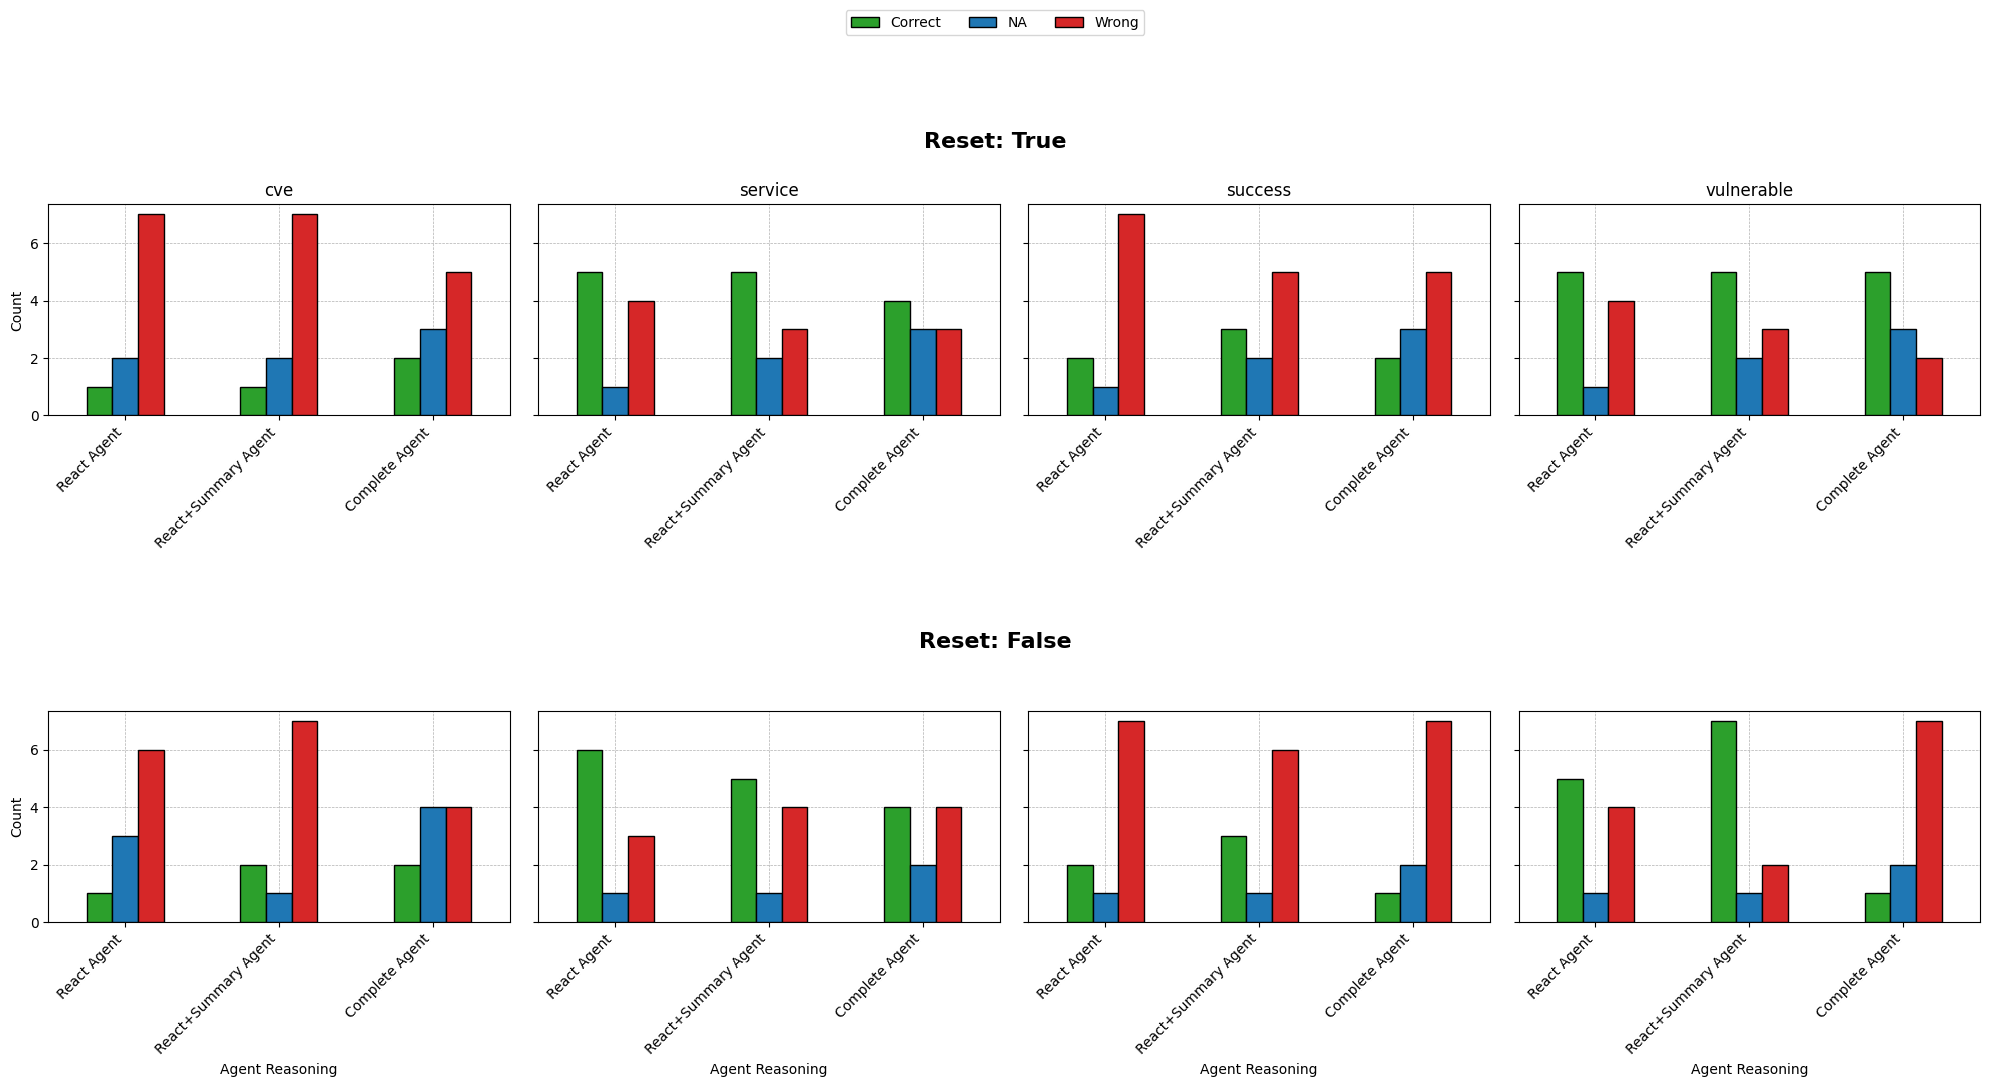

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings

warnings.filterwarnings('ignore')

# Define the custom color map
color_map = {'Correct': 'tab:green', 'NA': 'tab:blue', 'Wrong': 'tab:red'}

columns_to_explore = ['cve_check', 'service_check', 'success_check', 'vulnerable_check']
methods = res['method'].unique()

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10), sharey=True)

# Filter the data
res_true = res[res['reset'] == 'True']
res_false = res[res['reset'] == 'False']

# Create a unique legend
handles, labels = [], []
for column in columns_to_explore:
    data_true = res_true.groupby(['method', column]).size().unstack().fillna(0)
    handle, label = data_true.plot(kind='bar', ax=axes[0, columns_to_explore.index(column)], color=[color_map.get(x, 'black') for x in data_true.columns], edgecolor='black', zorder=3).get_legend_handles_labels()
    handles.extend(handle)
    labels.extend(label)
    axes[0, columns_to_explore.index(column)].get_legend().remove()
    axes[0, columns_to_explore.index(column)].grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0)

    data_false = res_false.groupby(['method', column]).size().unstack().fillna(0)
    data_false.plot(kind='bar', ax=axes[1, columns_to_explore.index(column)], legend=False, color=[color_map.get(x, 'black') for x in data_false.columns], edgecolor='black', zorder=3)
    axes[1, columns_to_explore.index(column)].grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0)

# Add the unique legend below the figure
fig.legend(handles[:3], labels[:3], loc='lower center', ncol=3, bbox_to_anchor=(0.5, 1.05))
axes = axes.flatten()

for ax, column in zip(axes, columns_to_explore * 2):
    ax.set_title(f'{column}'.replace('_check',''))
    if ax in axes[4:]:
        ax.set_xlabel('Agent Reasoning')        
        ax.set_title('')
    else:
        ax.set_xlabel('')

    ax.set_ylabel('Count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Add suptitles for each line
fig.suptitle('Reset: True', x=0.5, y=0.95, ha='center', va='center', fontsize=16, weight='bold')
fig.text(0.5, 0.45, 'Reset: False', ha='center', va='center', fontsize=16, weight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=1.4)  # Adjust the space between the two lines of figures
plt.show()



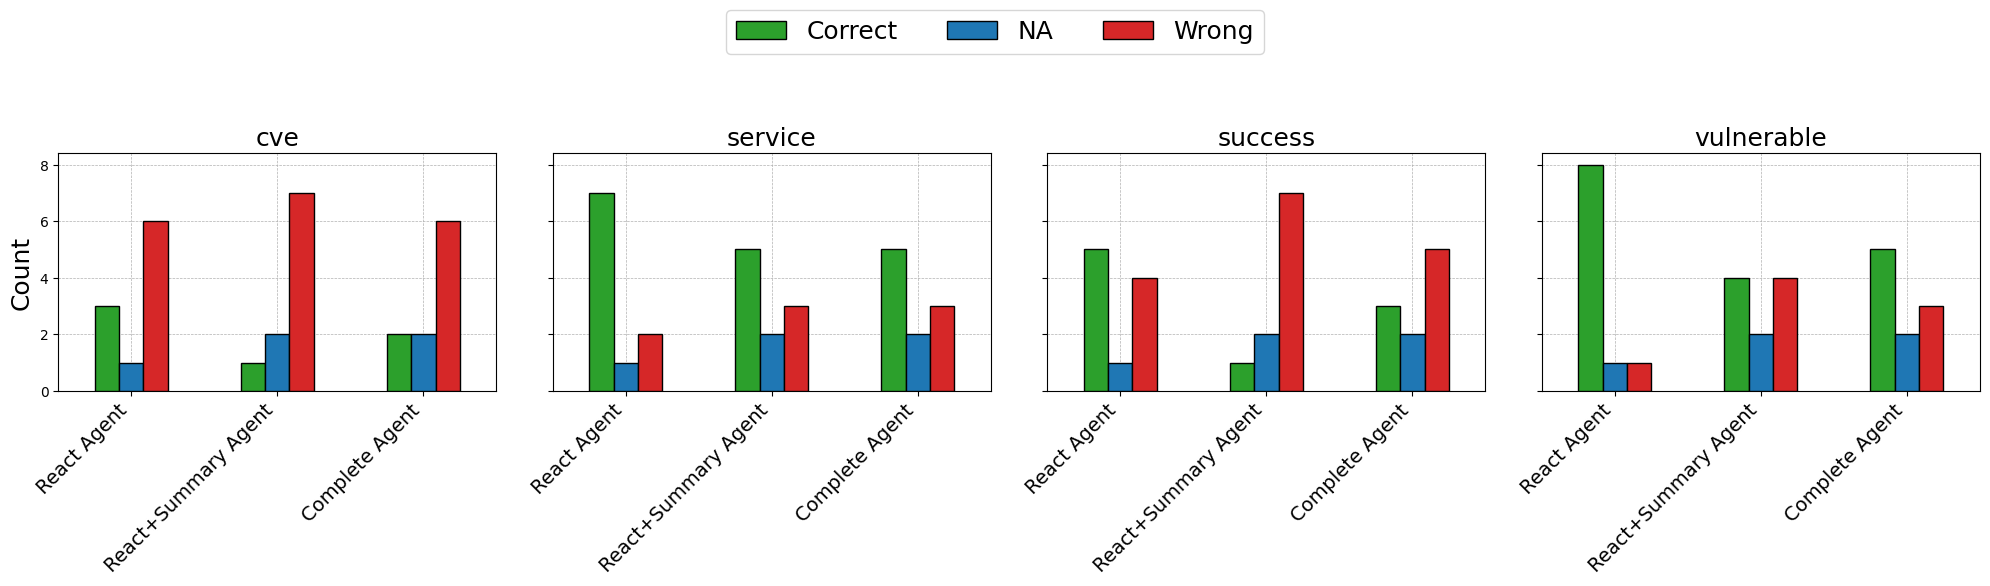

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings

react_results = pd.read_csv('results/react_agent_noReset_results.csv', delimiter=';').drop(columns=['Unnamed: 0'])
react_results['reset'] = 'False'

react_results['cve_true'] = df['cve']
react_results['service_true'] = df['service']
react_results['success_true'] = df['success']
react_results['vulnerable_true'] = df['vulnerable']

react_results['cve_check'] = react_results.apply(lambda x: cve_check(x['cve'], x['cve_true']), axis=1)
react_results['service_check'] = react_results.apply(lambda x: service_check(x['service'], x['service_true']), axis=1)
react_results['success_check'] = react_results.apply(lambda x: success_check(x['successful'], x['success_true']), axis=1)
react_results['vulnerable_check'] = react_results.apply(lambda x: vulnerable_check(x['is_vulnerable'], x['vulnerable_true']), axis=1)
react_results['method'] = 'React Agent'

react_summary_results = pd.read_csv('results/react_summary_agent_noReset_results.csv',delimiter=';').drop(columns=['Unnamed: 0'])
react_summary_results['reset'] = 'False'

react_summary_results['cve_true'] = df['cve']
react_summary_results['service_true'] = df['service']
react_summary_results['success_true'] = df['success']
react_summary_results['vulnerable_true'] = df['vulnerable']

react_summary_results['cve_check'] = react_summary_results.apply(lambda x: cve_check(x['cve'], x['cve_true']), axis=1)
react_summary_results['service_check'] = react_summary_results.apply(lambda x: service_check(x['service'], x['service_true']), axis=1)
react_summary_results['success_check'] = react_summary_results.apply(lambda x: success_check(x['successful'], x['success_true']), axis=1)
react_summary_results['vulnerable_check'] = react_summary_results.apply(lambda x: vulnerable_check(x['is_vulnerable'], x['vulnerable_true']), axis=1)
react_summary_results['method'] = 'React+Summary Agent'

complete_results = pd.read_csv('results/complete_agent_noReset_results.csv', delimiter=';').drop(columns=['Unnamed: 0'])
complete_results['reset'] = 'False'

complete_results['cve_true'] = df['cve']
complete_results['service_true'] = df['service']
complete_results['success_true'] = df['success']
complete_results['vulnerable_true'] = df['vulnerable']

complete_results['cve_check'] = complete_results.apply(lambda x: cve_check(x['cve'], x['cve_true']), axis=1)
complete_results['service_check'] = complete_results.apply(lambda x: service_check(x['service'], x['service_true']), axis=1)
complete_results['success_check'] = complete_results.apply(lambda x: success_check(x['successful'], x['success_true']), axis=1)
complete_results['vulnerable_check'] = complete_results.apply(lambda x: vulnerable_check(x['is_vulnerable'], x['vulnerable_true']), axis=1)
complete_results['method'] = 'Complete Agent'

res = [react_results, react_summary_results, complete_results]
res = pd.concat(res)

method_order = ['React Agent', 'React+Summary Agent', 'Complete Agent']
res['method'] = pd.Categorical(res['method'], categories=method_order, ordered=True)
res = res.sort_values('method')

# Define the custom color map
color_map = {'Correct': 'tab:green', 'NA': 'tab:blue', 'Wrong': 'tab:red'}

columns_to_explore = ['cve_check', 'service_check', 'success_check', 'vulnerable_check']
methods = res['method'].unique()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), sharey=True)

# Create a unique legend
handles, labels = [], []
for column in columns_to_explore:
    data_true = res.groupby(['method', column]).size().unstack().fillna(0)
    handle, label = data_true.plot(kind='bar', ax=axes[columns_to_explore.index(column)], color=[color_map.get(x, 'black') for x in data_true.columns], edgecolor='black', zorder=3).get_legend_handles_labels()
    handles.extend(handle)
    labels.extend(label)
    axes[columns_to_explore.index(column)].get_legend().remove()
    axes[columns_to_explore.index(column)].grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0)

# Add the unique legend below the figure
fig.legend(handles[:3], labels[:3], loc='lower center', ncol=3, bbox_to_anchor=(0.5, 1.05), fontsize=18)
axes = axes.flatten()

for ax, column in zip(axes, columns_to_explore):
    ax.set_title(f'{column}'.replace('_check',''), fontsize=18)
    ax.set_xlabel('', fontsize=18)
    ax.set_ylabel('Count', fontsize=18)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=1.4)  # Adjust the space between the two lines of figures
plt.show()

